# Topic modeling

Based on the identified topic clusters, a recommendation system will be made. In order for that to be possible, the result object of the topic model has to allow for distance calculation (cosine similarity or Jacard similarity). Also, I want a model that can assign a topic to new docs and calculate distance to docs in the model very easily. Preferrably, the model should allow updating.

Options: 
* __K-means clustering__:
    * sklearn
    * handy for plotting what the optimal number of clusters might be
    * does not do very well with a high number of clusters (use MiniBatch code for big data)
    * even cluster sizes. Maybe not the best choice here, I already know that there are way more syntax papers than morphology/phonology/semantics papers.
      
  
* __LDA__: 
    * exists both in Grahphlab and in Gensim. 
    * Some say only count vectors work with this.
    * Gensim: 
        * parallelizable. gensim.models.LdaMulticore()
        * Requires additional preparation of the doc vectors: 
            * terms have to be rows (not columns)
            * convert sparse matrix to gensim corpus
            * save a mapping (dict) of row id to word (token) for later use by gensim
            * has .print_topics method that gives you the most relevant words for each topic
            * can give you topic space: the probability of a doc belonging to a topic.
            * higher alpha allows for documents to be assigned to more topics
            * can decide on topic for new doc!
            * allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents. The model can also be updated with new documents for online training.
              
  
* __LSA__: 
    * Returns previously specified number of principal components. In order to know how well these components summarize the data: explained_variance
    * TruncatedSVD in sklearn. 
    * Both count and tfidf vectors. 
    * Can be used to calculate doc similarity.
    * gives you orthogonal vectors. Maybe not the best when topics have overlap.
      
  
* __NMF__: 
    * sklearn, both with count vectors and with tfidf.
    * .components_ gives you the degree in which a word belongs to a component (i.e., to a topic)
    * nmf is not required to give you orthogonal latent vectors, might be better if topics are not clearly separated
      
  
* __Hierarchical clustering (Ward)__:
    * from sklearn.cluster import AgglomerativeClustering or Ward
    * big data!
    * uneven cluster sizes
    * several distance metrics
    * I suspect that this one will do best...
      
  
* __DBSCAN__:
    * sklearn
    * not too many clusters
    * uneven cluster sizes
    * several distance metrics   
    
    
* __Semantic models__: 
    * train word2vec on the whole corpus (takes forever)
    * calculate similarity based on the semantic distance between the set of words in each paper. No topic modelling needed.

## 1. Code for evaluation

In [298]:
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np

def compute_similarities(doc_pkl, keyword_pkl):
    """ takes doc vectors and keyword vectors, computes cosine similarity and returns pearson correlation 
    between similarities. The higher the correltion, the better the topic model"""
    dtm_doc = joblib.load(doc_pkl)
    dtm_key = joblib.load(keyword_pkl)
    cs_doc = cosine_similarity(dtm_doc)
    cs_key = cosine_similarity(dtm_key)
    # in order to maintain single correlations and eliminate correlations with itself + flatten for calculating pearson
    ut_doc = np.triu(cs_doc, k=1).flatten()
    ut_key = np.triu(cs_key, k=1).flatten()
    return np.corrcoef(ut_doc, ut_key)[0,1]

In [383]:
print(compute_similarities('countvector.pkl', 'countvector_keywords.pkl'))

0.612346784837


In [384]:
print(compute_similarities('tfidf.pkl', 'tfidf_keywords.pkl'))

0.408467061703


In [385]:
print(compute_similarities('tfidf.pkl', 'countvector_keywords.pkl'))

0.562717897218


If we simply compute the document similarities based on the vectors without any topic modelling, Countvectors do better than tfidf vectors. Clearly, the keywords do not summarize the documents perfectly. We can use this as the baseline to evaluate the document similarities that come out of the topic models.

## 2. Topic modelling

### 2.1 K-means

This algorithm permits visualisation of error in the clustering (Silhouette score and inertia). It might be useful to get an idea of how many topics we are looking for.

In [4]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
dtm_count = joblib.load('countvector.pkl')
dtm_tfidf = joblib.load('tfidf.pkl')

In [45]:
inertia = []
silhouette = []
for k in range(2,50):
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km.fit(dtm_count)
    labels = km.labels_
    silhouette.append(silhouette_score(dtm_count, labels, metric='cosine'))
    inertia.append(km.inertia_)

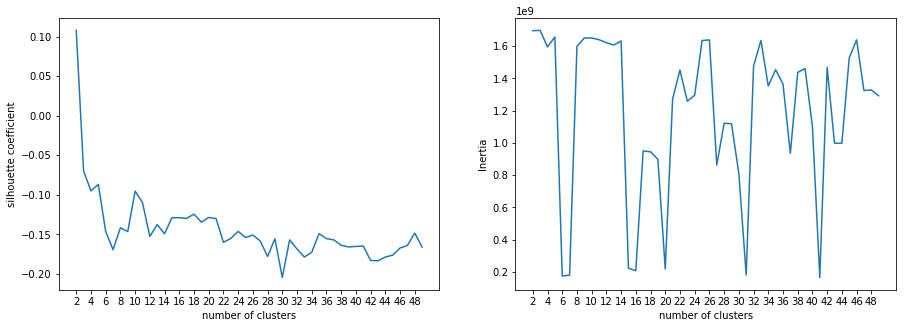

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,50)
ax1.plot(k_clusters, silhouette)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_xticks(range(2,50,2))

ax2.plot(k_clusters, inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia')

In [48]:
inertia = []
silhouette = []
for k in range(51,100):
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km.fit(dtm_count)
    labels = km.labels_
    silhouette.append(silhouette_score(dtm_count, labels, metric='cosine'))
    inertia.append(km.inertia_)

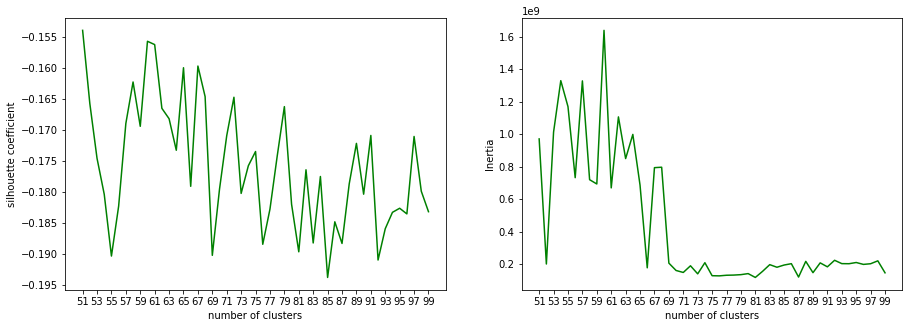

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(51,100)

ax1.plot(k_clusters, silhouette, color = 'g')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_xticks(range(51,100,2))

ax2.plot(k_clusters, inertia, color='g')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia')

Clusters are hard to seperate. This is expected: there are topics and subtopics, and the relation between them is many-to-many. Also, K-Means looks for even sized-clusters. It does not take into account that syntactic papers are more represented in the dataset.  
Let's see what the keyword vectors tell us:

In [6]:
dtm_ckey = joblib.load('countvector_keywords.pkl')
dtm_tkey = joblib.load('tfidf_keywords.pkl')

In [51]:
inertia = []
silhouette = []
for k in range(2,100):
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km.fit(dtm_ckey)
    labels = km.labels_
    silhouette.append(silhouette_score(dtm_count, labels, metric='cosine'))
    inertia.append(km.inertia_)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:204: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


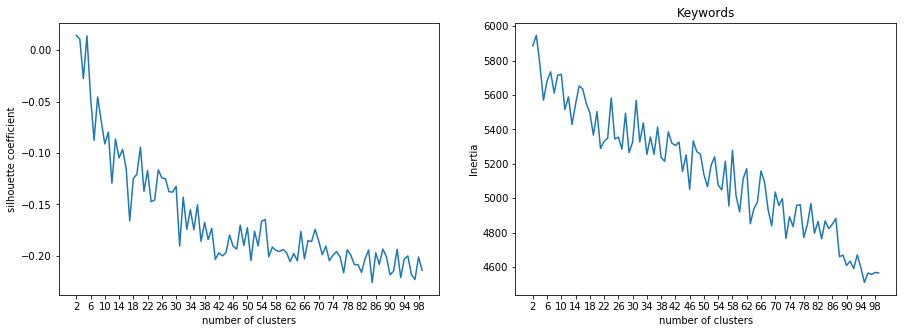

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,100)
plt.title('Keywords')
ax1.plot(k_clusters, silhouette)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_xticks(range(2,100,4))

ax2.plot(k_clusters, inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia')

No elbows or clear peaks whatsoever. This is actually expected, the keywords are supposed to be topics by themselves.    
Let's check with tfidf vectors:

In [57]:
inertia = []
silhouette = []
for k in range(2,100):
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km.fit(dtm_tfidf)
    labels = km.labels_
    silhouette.append(silhouette_score(dtm_count, labels, metric='cosine'))
    inertia.append(km.inertia_)

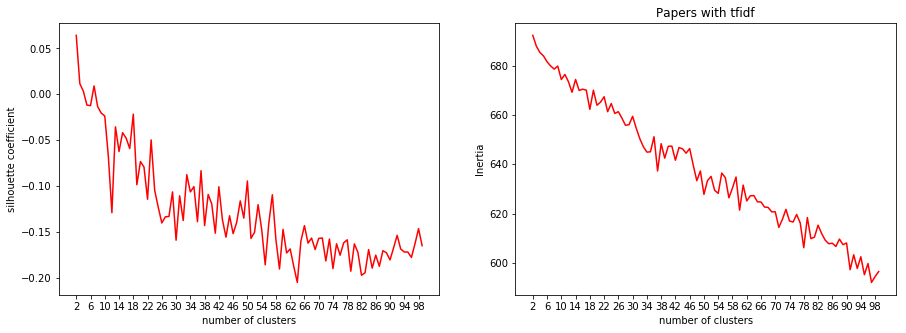

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,100)
plt.title('Papers with tfidf')
ax1.plot(k_clusters, silhouette, color='r')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_xticks(range(2,100,4))

ax2.plot(k_clusters, inertia, color='r')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia')

In [59]:
inertia = []
silhouette = []
for k in range(2,100):
    km = MiniBatchKMeans(n_clusters=k, random_state=1)
    km.fit(dtm_tkey)
    labels = km.labels_
    silhouette.append(silhouette_score(dtm_count, labels, metric='cosine'))
    inertia.append(km.inertia_)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:204: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


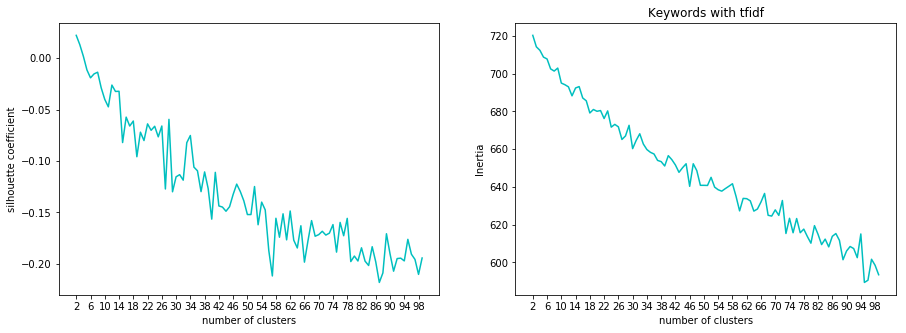

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,100)
plt.title('Keywords with tfidf')
ax1.plot(k_clusters, silhouette, color='c')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_xticks(range(2,100,4))

ax2.plot(k_clusters, inertia, color='c')
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia')

Same story. We need an algorithm that can identify uneven topics, and that can deal with the many-to-many relations between topics and sub topics.

## 2.2 LDA

Allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents. The model __can also be updated with new documents for online training__.

In [8]:
from gensim import models, similarities, matutils
import pickle

In [73]:
with open('lda_counts.pkl', 'rb') as pkl:
    counts = joblib.load(pkl)
print(counts.shape)

(324789, 743)


In [74]:
corpus = matutils.Sparse2Corpus(counts)

In [75]:
with open('lda_dict.pkl', 'rb') as pkl:
    id2word = pickle.load(pkl)

In [76]:
list(id2word.items())[10]

(176680, 'like')

In [77]:
lda = models.LdaMulticore(num_topics=50, corpus=corpus, id2word=id2word, passes=10)

In [78]:
lda.save('lda_model.pkl')

In [79]:
lda.print_topics(num_topics = 50, num_words=8)

[(0,
  '0.011*"ellipsis" + 0.010*"case" + 0.009*"john" + 0.007*"focus" + 0.007*"clause" + 0.006*"question" + 0.006*"like" + 0.005*"a."'),
 (1,
  '0.010*"word" + 0.008*"e" + 0.007*"root" + 0.005*"experiment" + 0.005*"result" + 0.004*"japanese" + 0.004*"item" + 0.004*"nonce"'),
 (2,
  '0.008*"subject" + 0.008*"argument" + 0.006*"case" + 0.005*"analysis" + 0.005*"◦" + 0.004*"position" + 0.004*"feature" + 0.004*"japanese"'),
 (3,
  '0.009*"case" + 0.006*"clause" + 0.006*"verb" + 0.005*"čto" + 0.005*"argument" + 0.004*"structure" + 0.004*"a." + 0.004*"subject"'),
 (4,
  '0.008*"\ue049e" + 0.007*"conditional" + 0.006*"agreement" + 0.006*"past" + 0.006*"index" + 0.006*"present" + 0.006*"p" + 0.005*"counterfactual"'),
 (5,
  '0.010*"verb" + 0.007*"v" + 0.007*"vp" + 0.006*"head" + 0.006*"auxiliary" + 0.005*"case" + 0.005*"a." + 0.005*"position"'),
 (6,
  '0.040*"clitic" + 0.017*"dative" + 0.009*"french" + 0.007*"case" + 0.007*"person" + 0.007*"le" + 0.007*"kayne" + 0.006*"accusative"'),
 (7,
  

For document similarity: get vectors that represent topic+probability for each document, reconstruct missing topic probabilities, and calculate similarity between these vectors.

In [80]:
from collections import defaultdict

def make_topic_vectors_lda(lda, corpus, n_topics):
    matrix = []
    #transform corpus to topic space. this gives an iterator
    lda_corpus = lda[corpus]
    # extract the actual topic space from the iterator
    topic_space = [doc for doc in lda_corpus]
    for doc in topic_space:
        topic_dic = defaultdict(lambda: 0.0)
        for topic in doc:
            topic_dic[topic[0]] = topic[1]
        matrix.append([topic_dic[n] for n in range(n_topics)])
    return np.array(matrix)     

In [81]:
probas_lda = make_topic_vectors_lda(lda, corpus, 50)
joblib.dump(probas_lda, 'topic_vectors_lda.pkl') 
print(compute_similarities('topic_vectors_lda.pkl', 'countvector_keywords.pkl'))

0.247638498841


In [82]:
print(compute_similarities('topic_vectors_lda.pkl', 'tfidf_keywords.pkl'))

0.186039574611


For updating the model:

In [83]:
def convert_for_update(doc):
    # tokenize with personalized tokenizer, transform using vectorizer that was fitted on the whole initial corpus,
    # convert to Gensim corpus
    tokenized = my_tokenizer(doc)
    vectorizer = joblib.load('update_vectorizer.pkl')
    counts = vectorizer.transform(tokenized)
    return counts

def update_lda(model, doc):
    counts = convert_for_update(doc).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    model.update(corpus)
    joblib.dump(model, str(model))
    return model

## 2.3 NMF

In [87]:
from sklearn.decomposition import NMF

In [88]:
nmf = NMF(n_components=50)
nmf.fit(dtm_tfidf)
joblib.dump(nmf, 'nmf_model.pkl')

['nmf_model.pkl']

In [89]:
transformed = nmf.transform(dtm_tfidf)

In [90]:
joblib.dump(transformed, 'nmf.pkl')

['nmf.pkl']

In [91]:
print(compute_similarities('nmf.pkl', 'countvector_keywords.pkl'))

0.421975956589


In [92]:
print(compute_similarities('nmf.pkl', 'tfidf_keywords.pkl'))

0.380488638286


In [183]:
nmf = NMF(n_components=20)
nmf.fit(dtm_tfidf)
joblib.dump(nmf, 'nmf_model_reduced.pkl')
transformed = nmf.transform(dtm_tfidf)
joblib.dump(transformed, 'nmf_reduced.pkl')
print(compute_similarities('nmf_reduced.pkl', 'countvector_keywords.pkl'))

0.484011449677


In [184]:
print(compute_similarities('nmf_reduced.pkl', 'tfidf_keywords.pkl'))

0.391884450944


NMF is better than LDA at identifying the topics in the same way as the keywords do. Less topics is better though. Yet, the no topic-model system is better.  
Let's see if NMF with the count vectorizer gives different results:

In [293]:
nmf = NMF(n_components=50)
nmf.fit(dtm_count)
joblib.dump(nmf, 'nmf_count_model.pkl')

['nmf_count_model.pkl']

In [294]:
transformed = nmf.transform(dtm_count)
joblib.dump(transformed, 'nmf_count.pkl')

['nmf_count.pkl']

In [295]:
print(compute_similarities('nmf_count.pkl', 'countvector_keywords.pkl'))

0.472410087204


In [296]:
print(compute_similarities('nmf_count.pkl', 'tfidf_keywords.pkl'))

0.367971621847


In [297]:
nmf.reconstruction_err_nstruction_err_

7206.4137186168655

In [320]:
nmf = NMF(n_components=20)
nmf.fit(dtm_count)
joblib.dump(nmf, 'nmf_count_reduced.pkl')
transformed = nmf.transform(dtm_count)
joblib.dump(transformed, 'nmf_count_reduced.pkl')
print(compute_similarities('nmf_count_reduced.pkl', 'countvector_keywords.pkl'))

0.548053707242


In [309]:
transformed.shape

(743, 50)

In [292]:
nmf.reconstruction_err_

9567.266706684544

We are getting better.
So far: NMF with count vectors and 20 topics gives a result most similar to the keywords.

## 2.4 Hierarchical clustering

Returns the cluster to which a doc belongs. The similarity matrix will consist of zeros and ones (one = in cluster). 
Best score when 20 topics are searched for.

In [93]:
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

In [253]:
hc = AgglomerativeClustering(n_clusters = 20, affinity = 'cosine', linkage='complete')

In [254]:
fitted = hc.fit_predict(dtm_count.toarray())

In [283]:
Counter(fitted)

Counter({0: 165,
         1: 5,
         2: 2,
         3: 375,
         4: 58,
         5: 2,
         6: 32,
         7: 20,
         8: 14,
         9: 2,
         10: 50,
         11: 1,
         12: 1,
         13: 1,
         14: 7,
         15: 1,
         16: 1,
         17: 4,
         18: 1,
         19: 1})

In [255]:
fitted2 = hc.fit_predict(dtm_tfidf.toarray())

In [284]:
Counter(fitted2)

Counter({0: 118,
         1: 253,
         2: 47,
         3: 243,
         4: 10,
         5: 2,
         6: 12,
         7: 6,
         8: 3,
         9: 34,
         10: 2,
         11: 1,
         12: 2,
         13: 1,
         14: 3,
         15: 1,
         16: 1,
         17: 1,
         18: 2,
         19: 1})

In [256]:
import pandas as pd
def to_similarity_matrix(fitted):
    member_list = []
    for doc, topic in enumerate(list(fitted)):
        member_list.append([doc, topic, 1])
    df = pd.DataFrame(member_list, columns = ['doc', 'topic', 'member'])
    return df.pivot_table(df, index=['doc'], columns=['topic']).fillna(0)        

In [257]:
sim = to_similarity_matrix(fitted)

In [258]:
count_key = joblib.load('countvector_keywords.pkl')
cs_doc = cosine_similarity(sim)
cs_key = cosine_similarity(count_key)
ut_doc = np.triu(cs_doc, k=1).flatten()
ut_key = np.triu(cs_key, k=1).flatten()
print(np.corrcoef(ut_doc, ut_key)[0,1])

0.375454407947


In [259]:
sim2 = to_similarity_matrix(fitted2)

In [260]:
count_key = joblib.load('countvector_keywords.pkl')
cs_doc = cosine_similarity(sim2)
cs_key = cosine_similarity(count_key)
ut_doc = np.triu(cs_doc, k=1).flatten()
ut_key = np.triu(cs_key, k=1).flatten()
print(np.corrcoef(ut_doc, ut_key)[0,1])

0.32130149891


## 2.5 DBSCAN
For DBSCAN, you do not need to specify the number of clusters that you are looking for, you just specify the maximum distance. Based on the keyword distances, I will set the threshold, and see how many clusters come out.

In [300]:
keys = joblib.load('countvector_keywords.pkl')
for row in cosine_similarity(keys):
    print(sorted(row, reverse=True)[1:20])

[0.41812100500354543, 0.39886201760873286, 0.39886201760873286, 0.39167472590032015, 0.37310125362231822, 0.35533452725935077, 0.35176323534072423, 0.35176323534072423, 0.3481553119113957, 0.3481553119113957, 0.3481553119113957, 0.3458572319330373, 0.34188172937891381, 0.33920026264998404, 0.33709993123162107, 0.33449680400283632, 0.33371190623595737, 0.33371190623595737, 0.33371190623595731]
[0.47140452079103179, 0.47140452079103179, 0.46291004988627577, 0.43301270189221941, 0.43301270189221941, 0.43301270189221941, 0.43301270189221941, 0.4166666666666668, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.40824829046386307, 0.39167472590032015, 0.3857583749052298]
[0.49999999999999989, 0.49999999999999989, 0.49999999999999989, 0.49999999999999989, 0.49999999999999989, 0.49999999999999989, 0.49029033784546006, 0.48666426339228752, 0.44721359549995793, 0.44721359549995

In [187]:
from sklearn.cluster import DBSCAN

In [380]:
db = DBSCAN(eps = 0.5, min_samples=2, metric='cosine', n_jobs=-1, algorithm='brute')

In [381]:
fit_db = db.fit_predict(dtm_count)

In [382]:
Counter(fit_db)

Counter({-1: 268,
         0: 344,
         1: 5,
         2: 5,
         3: 2,
         4: 8,
         5: 2,
         6: 14,
         7: 4,
         8: 5,
         9: 2,
         10: 2,
         11: 3,
         12: 4,
         13: 2,
         14: 3,
         15: 2,
         16: 4,
         17: 7,
         18: 4,
         19: 3,
         20: 2,
         21: 2,
         22: 2,
         23: 2,
         24: 2,
         25: 4,
         26: 2,
         27: 3,
         28: 2,
         29: 3,
         30: 2,
         31: 2,
         32: 3,
         33: 2,
         34: 2,
         35: 2,
         36: 2,
         37: 2,
         38: 3,
         39: 2,
         40: 2,
         41: 2})

In [356]:
sim_db = to_similarity_matrix(fit_db)
count_key = joblib.load('countvector_keywords.pkl')
cs_doc = cosine_similarity(sim_db)
cs_key = cosine_similarity(count_key)
ut_doc = np.triu(cs_doc, k=1).flatten()
ut_key = np.triu(cs_key, k=1).flatten()
print(np.corrcoef(ut_doc, ut_key)[0,1])

0.28221977455


There is clearly lots of noise in the data. Is it possible to reduce the noise?  
Ideas:
* take out noise from the papers themselves
* dimensionality reduction. Is it possible to run output of NMF through DBSCAN?

In [335]:
nmf_reduced = joblib.load('nmf_count_reduced.pkl')
db2 = DBSCAN(eps = 0.2, min_samples=2, metric='cosine', n_jobs=-1, algorithm='brute')
fit_db_nmf = db2.fit_predict(nmf_reduced)

In [336]:
Counter(fit_db_nmf)

Counter({-1: 14, 0: 711, 1: 3, 2: 4, 3: 2, 4: 3, 5: 2, 6: 2, 7: 2})

In [337]:
sim_db_nmf = to_similarity_matrix(fit_db_nmf)
count_key = joblib.load('countvector_keywords.pkl')
cs_doc = cosine_similarity(sim_db_nmf)
cs_key = cosine_similarity(count_key)
ut_doc = np.triu(cs_doc, k=1).flatten()
ut_key = np.triu(cs_key, k=1).flatten()
print(np.corrcoef(ut_doc, ut_key)[0,1])

0.53410075674


Dimensionality reduction does not help much. Less noise, but also most papers are assigned to the same topic. I know that there is topic inbalcen, but not that much...  
Let's try to take noise out of the papers themselves: update notebook 'preparation' and new notebook 'modeling final'.